<a href="https://colab.research.google.com/github/sirsjosh/Computer-Vision/blob/main/calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>Stereo Camera Calibration</b></h1>

<h2> connect to google drive </h2>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2> Install Stereo Vision Library and Import some we'll need </h2>

In [2]:
!pip3 install stereovision

<h2> imports </h2>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import os

from stereovision.calibration import StereoCalibrator
from stereovision.calibration import StereoCalibration
from stereovision.exceptions import ChessboardNotFoundError

<h2> Change Working Directory </h2>

In [4]:
os.chdir('/content/drive/MyDrive/calibration/')

In [5]:
%pwd

'/content/drive/MyDrive/calibration'

<h2> get images </h2>

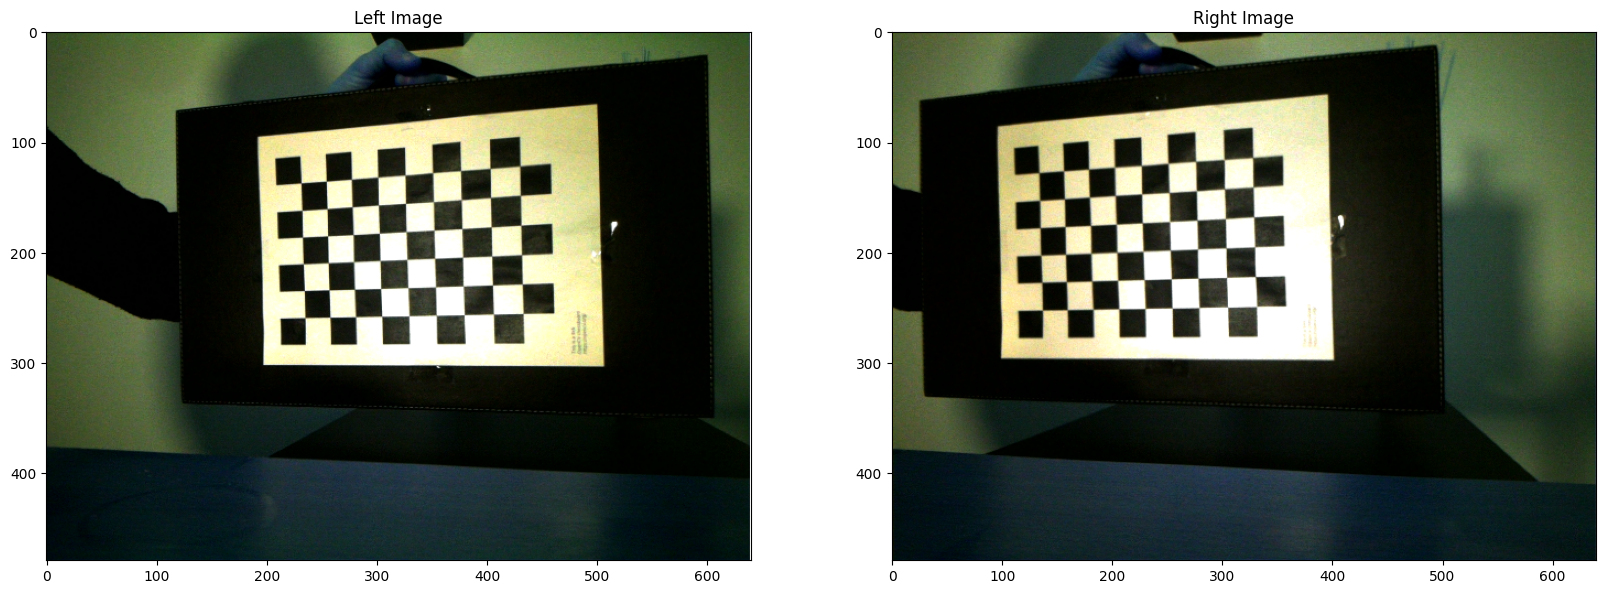

In [6]:
left = sorted(glob.glob('images/left/*.png'))
right = sorted(glob.glob('images/right/*.png'))

img = cv2.imread(left[0])
img2 = cv2.imread(right[0])

f, (ax0, ax1) = plt.subplots(1,2,figsize=(20,10))
ax0.imshow(img)
ax0.set_title("Left Image")
ax1.imshow(img2)
ax1.set_title("Right Image")
plt.show()

In [7]:
## These have been defined earlier.
img_shape = (640,480)
rows = 6
columns = 9
square_size = 2.4

# Call the Stereo Calibrator Object
calibrator = StereoCalibrator(rows, columns, square_size, img_shape)

# Define an empty counter and your number of images
counter = 0
total_photos= 30

# Call the get_corners function
# Warning, on Colab, it's better not to use cv2.imshow(). Therefore, set the last parameter for add_corners as False

while counter != total_photos:
    counter += 1
    print ('Import pair No ' + str(counter))
    leftName = left[counter-1]
    rightName = right[counter-1]
    imgLeft = cv2.imread(leftName,1)
    imgRight = cv2.imread(rightName,1)
    if os.path.isfile(leftName) and os.path.isfile(rightName):
        try:
            calibrator._get_corners(imgLeft)
            calibrator._get_corners(imgRight)
        except ChessboardNotFoundError as error:
            print (error)
            print ("Pair No "+ str(counter) + " ignored")
        else:
            calibrator.add_corners((imgLeft, imgRight), False)
print ('End cycle')

Import pair No 1
Import pair No 2
Import pair No 3
Import pair No 4
Import pair No 5
Import pair No 6
Import pair No 7
Import pair No 8
Import pair No 9
Import pair No 10
Import pair No 11
Import pair No 12
Import pair No 13
Import pair No 14
Import pair No 15
Import pair No 16
Import pair No 17
Import pair No 18
Import pair No 19
Import pair No 20
Import pair No 21
Import pair No 22
Import pair No 23
Import pair No 24
Import pair No 25
Import pair No 26
Import pair No 27
Import pair No 28
Import pair No 29
Import pair No 30
End cycle


<h2> Calibrate Cameras </h2>

In [8]:
print ('Starting calibration... It can take several minutes!')
calibration = calibrator.calibrate_cameras()
print ('Calibration complete!')

print(calibration)

Starting calibration... It can take several minutes!
Calibration complete!
cam_mats:
{'left': array([[564.31521506,   0.        , 313.83244476],
       [  0.        , 564.31521506, 243.75510161],
       [  0.        ,   0.        ,   1.        ]]), 'right': array([[564.31521506,   0.        , 314.33003917],
       [  0.        , 564.31521506, 242.57990443],
       [  0.        ,   0.        ,   1.        ]])}
dist_coefs:
{'left': array([[-0.01323548,  1.37005953,  0.        ,  0.        , -8.18251314]]), 'right': array([[-0.01371354,  0.41440668,  0.        ,  0.        , -2.26195551]])}
rot_mat:
[[ 0.99953396 -0.00307579 -0.03037096]
 [ 0.00285026  0.99996806 -0.00746637]
 [ 0.03039296  0.00737633  0.99951081]]
trans_vec:
[[-7.72048683]
 [-0.13837239]
 [-0.8389619 ]]
e_mat:
[[-1.81428491e-03  8.37914427e-01 -1.44568700e-01]
 [-6.03922484e-01  5.95293196e-02  7.74219012e+00]
 [ 1.16302491e-01 -7.72066588e+00  5.34415337e-02]]
f_mat:
[[-3.96096110e-08  1.82934138e-05 -6.22779372e-03]
 [

In [9]:
calibration.export('calib_result')

<h2> Trying to undistort the images </h2>

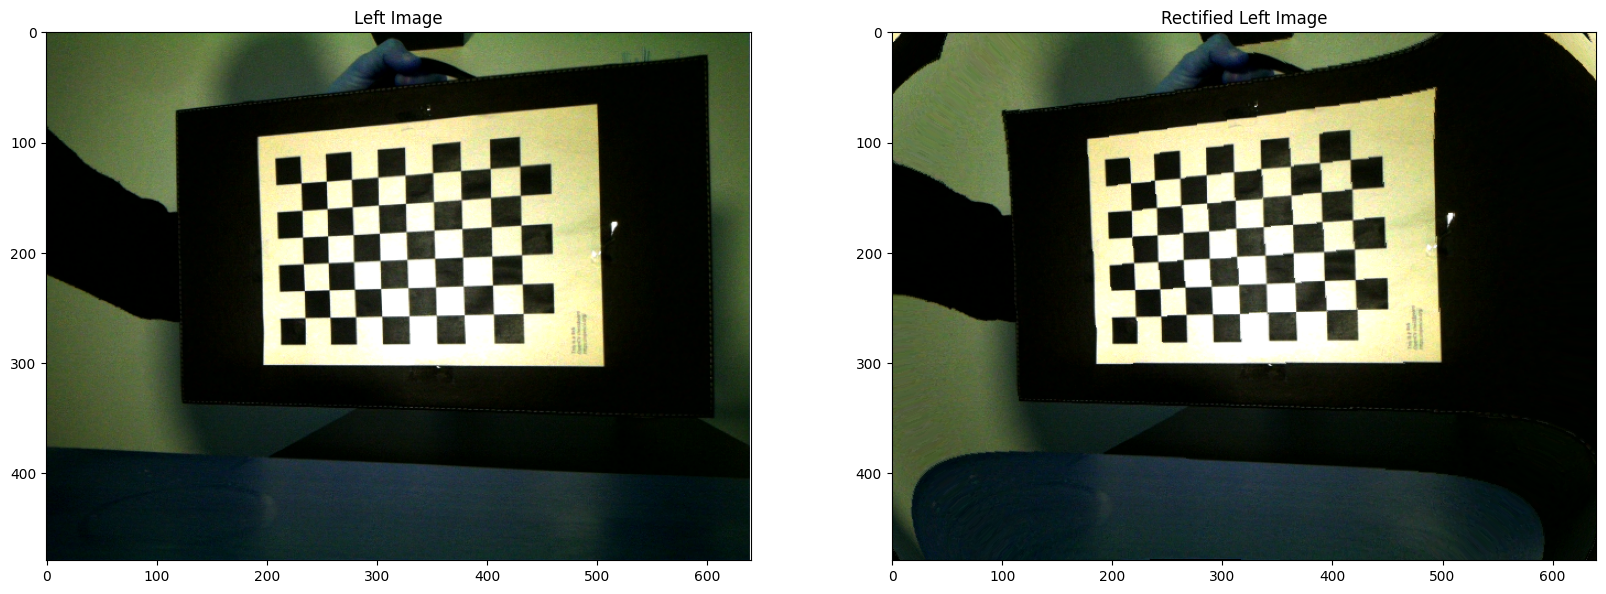

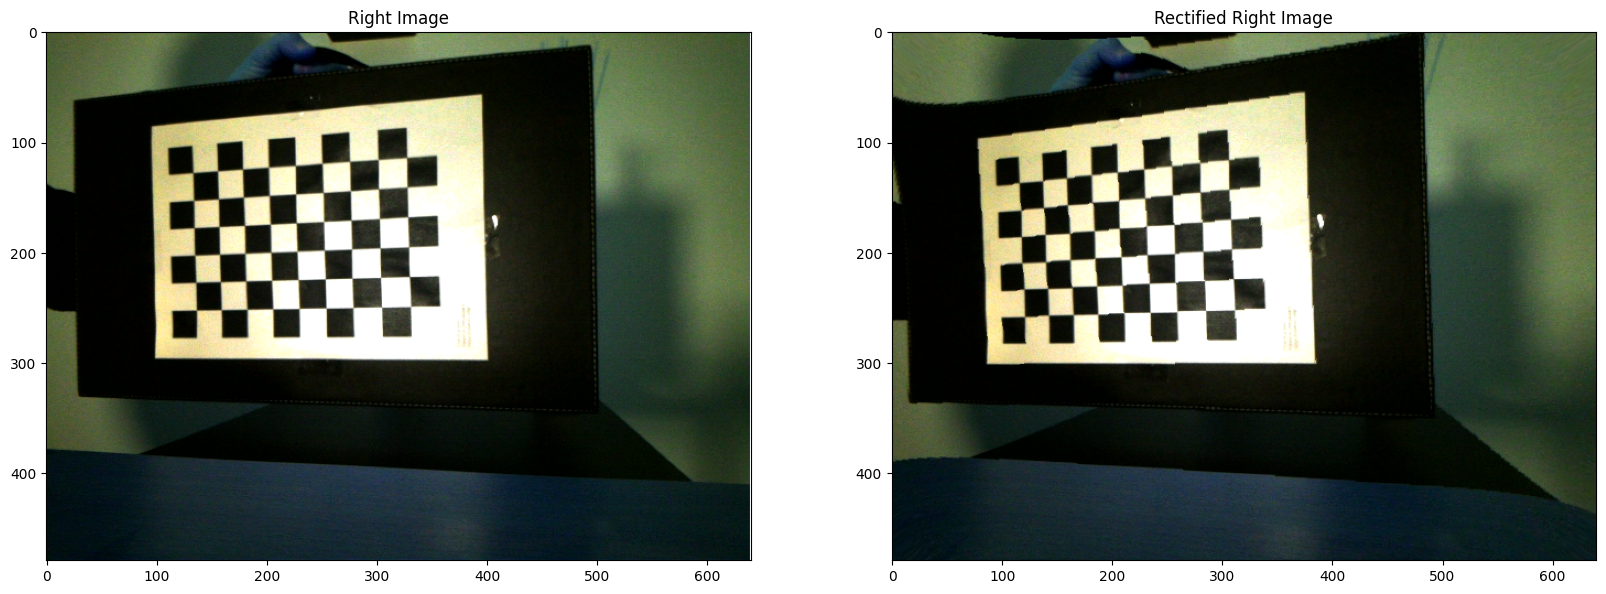

In [10]:
imgLeft = cv2.imread(left[0])
imgRight = cv2.imread(right[0])

rectified_pair = calibration.rectify((imgLeft, imgRight))

f, (ax0, ax1)= plt.subplots(1,2, figsize=(20,10))
ax0.imshow(imgLeft)
ax0.set_title("Left Image")
ax1.imshow(rectified_pair[0])
ax1.set_title("Rectified Left Image")
plt.show()
f, (ax2, ax3)= plt.subplots(1,2, figsize=(20,10))
ax2.imshow(imgRight)
ax2.set_title("Right Image")
ax3.imshow(rectified_pair[1])
ax3.set_title("Rectified Right Image")
plt.show()

<p> As you can see from the results above we have radial distortion. </br>
😕😕😕 We need to use the Flags; but they're inside the function and cannot be changed; as you can see here: <a href='https://github.com/erget/StereoVision/blob/f09d67140e8164969ae3458fc4df658fbbf3649b/stereovision/calibration.py#L218'>https://github.com/erget/StereoVision/blob/f09d67140e8164969ae3458fc4df658fbbf3649b/stereovision/calibration.py#L218<a>
 </p>

In [11]:
#change from this
'''
def calibrate_cameras(self):
        """Calibrate cameras based on found chessboard corners."""
        criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
                    100, 1e-5)
        flags = (cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_ZERO_TANGENT_DIST +
                 cv2.CALIB_SAME_FOCAL_LENGTH)
        calib = StereoCalibration()
        (calib.cam_mats["left"], calib.dist_coefs["left"],
         calib.cam_mats["right"], calib.dist_coefs["right"],
         calib.rot_mat, calib.trans_vec, calib.e_mat,
         calib.f_mat) = cv2.stereoCalibrate(self.object_points,
                                            self.image_points["left"],
                                            self.image_points["right"],
                                            self.image_size,
                                            calib.cam_mats["left"],
                                            calib.dist_coefs["left"],
                                            calib.cam_mats["right"],
                                            calib.dist_coefs["right"],
                                            calib.rot_mat,
                                            calib.trans_vec,
                                            calib.e_mat,
                                            calib.f_mat,
                                            criteria=criteria,
                                            flags=flags)[1:]
        (calib.rect_trans["left"], calib.rect_trans["right"],
         calib.proj_mats["left"], calib.proj_mats["right"],
         calib.disp_to_depth_mat, calib.valid_boxes["left"],
         calib.valid_boxes["right"]) = cv2.stereoRectify(calib.cam_mats["left"],
                                                      calib.dist_coefs["left"],
                                                      calib.cam_mats["right"],
                                                      calib.dist_coefs["right"],
                                                      self.image_size,
                                                      calib.rot_mat,
                                                      calib.trans_vec,
                                                      flags=0)
        for side in ("left", "right"):
            (calib.undistortion_map[side],
             calib.rectification_map[side]) = cv2.initUndistortRectifyMap(
                                                        calib.cam_mats[side],
                                                        calib.dist_coefs[side],
                                                        calib.rect_trans[side],
                                                        calib.proj_mats[side],
                                                        self.image_size,
                                                        cv2.CV_32FC1)
        # This is replaced because my results were always bad. Estimates are
        # taken from the OpenCV samples.
        width, height = self.image_size
        focal_length = 0.8 * width
        calib.disp_to_depth_mat = np.float32([[1, 0, 0, -0.5 * width],
                                              [0, -1, 0, 0.5 * height],
                                              [0, 0, 0, -focal_length],
                                              [0, 0, 1, 0]])
        return calib
'''

'\ndef calibrate_cameras(self):\n        """Calibrate cameras based on found chessboard corners."""\n        criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,\n                    100, 1e-5)\n        flags = (cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_ZERO_TANGENT_DIST +\n                 cv2.CALIB_SAME_FOCAL_LENGTH)\n        calib = StereoCalibration()\n        (calib.cam_mats["left"], calib.dist_coefs["left"],\n         calib.cam_mats["right"], calib.dist_coefs["right"],\n         calib.rot_mat, calib.trans_vec, calib.e_mat,\n         calib.f_mat) = cv2.stereoCalibrate(self.object_points,\n                                            self.image_points["left"],\n                                            self.image_points["right"],\n                                            self.image_size,\n                                            calib.cam_mats["left"],\n                                            calib.dist_coefs["left"],\n                                            

In [12]:
#to this
def calibrate_cameras(calibrator):
        """Calibrate cameras based on found chessboard corners."""
        criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        flags = (cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_ZERO_TANGENT_DIST +
                 cv2.CALIB_SAME_FOCAL_LENGTH + cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3)
        calib = StereoCalibration()
        (retval, calib.cam_mats["left"], calib.dist_coefs["left"], calib.cam_mats["right"], calib.dist_coefs["right"],
        calib.rot_mat, calib.trans_vec, calib.e_mat, calib.f_mat) = cv2.stereoCalibrate(calibrator.object_points,
                                            calibrator.image_points["left"],
                                            calibrator.image_points["right"],calib.cam_mats["left"],
                                            calib.dist_coefs["left"],
                                            calib.cam_mats["right"],
                                            calib.dist_coefs["right"],calibrator.image_size,calib.rot_mat,
                                            calib.trans_vec,
                                            calib.e_mat,
                                            calib.f_mat,
                                            flags, criteria)

        (calib.rect_trans["left"], calib.rect_trans["right"],
         calib.proj_mats["left"], calib.proj_mats["right"],
         calib.disp_to_depth_mat, calib.valid_boxes["left"],
         calib.valid_boxes["right"]) = cv2.stereoRectify(calib.cam_mats["left"],
                                                      calib.dist_coefs["left"],
                                                      calib.cam_mats["right"],
                                                      calib.dist_coefs["right"],
                                                      calibrator.image_size,
                                                      calib.rot_mat,
                                                      calib.trans_vec,
                                                      flags=0)
        for side in ("left", "right"):
            (calib.undistortion_map[side],
             calib.rectification_map[side]) = cv2.initUndistortRectifyMap(
                                                        calib.cam_mats[side],
                                                        calib.dist_coefs[side],
                                                        calib.rect_trans[side],
                                                        calib.proj_mats[side],
                                                        calibrator.image_size,
                                                        cv2.CV_32FC1)
        # This is replaced because my results were always bad. Estimates are
        # taken from the OpenCV samples.
        width, height = calibrator.image_size
        focal_length = 0.8 * width
        calib.disp_to_depth_mat = np.float32([[1, 0, 0, -0.5 * width],
                                              [0, -1, 0, 0.5 * height],
                                              [0, 0, 0, -focal_length],
                                              [0, 0, 1, 0]])
        return calib

In [13]:
#Calibrate again, and compare
print ('Starting calibration... It can take several minutes!')
result_calib = calibrate_cameras(calibrator)
print ('Calibration complete!')

print(result_calib)

Starting calibration... It can take several minutes!
Calibration complete!
cam_mats:
{'left': array([[564.95467037,   0.        , 312.28277381],
       [  0.        , 564.95467037, 244.10548945],
       [  0.        ,   0.        ,   1.        ]]), 'right': array([[564.95467037,   0.        , 312.59219831],
       [  0.        , 564.95467037, 241.87732631],
       [  0.        ,   0.        ,   1.        ]])}
dist_coefs:
{'left': array([[0., 0., 0., 0., 0.]]), 'right': array([[0., 0., 0., 0., 0.]])}
rot_mat:
[[ 0.99953873 -0.00320224 -0.03020038]
 [ 0.00306952  0.99998543 -0.00444006]
 [ 0.03021416  0.00434531  0.999534  ]]
trans_vec:
[[-7.71622469]
 [-0.20060141]
 [-0.76158707]]
e_mat:
[[-3.72330047e-03  7.60704298e-01 -2.03889418e-01]
 [-5.28096513e-01  3.59681432e-02  7.73562917e+00]
 [ 1.76823811e-01 -7.71675465e+00  2.82022225e-02]]
f_mat:
[[-9.11151516e-08  1.86156578e-05 -7.33457303e-03]
 [-1.29233711e-05  8.80198320e-07  1.10768662e-01]
 [ 5.59900334e-03 -1.12718840e-01  1.0000

<h2> Finally, let's rectify again </h2>

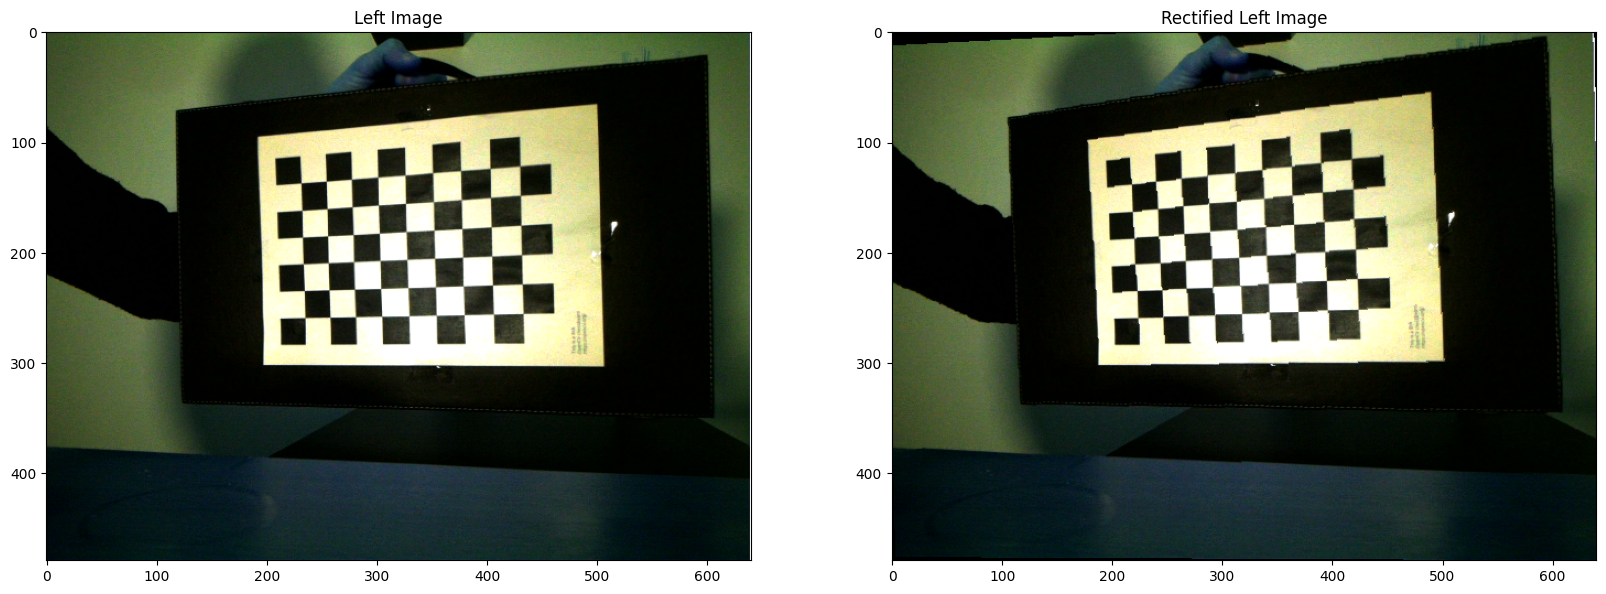

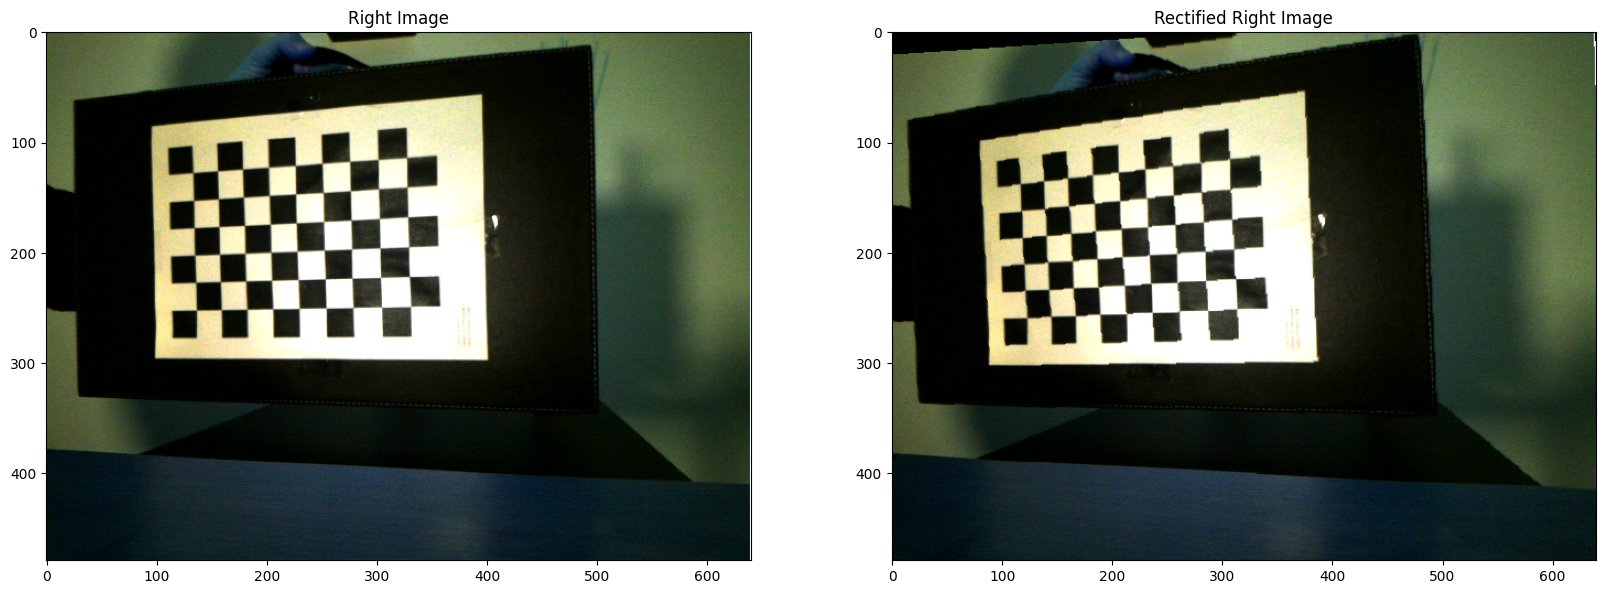

In [14]:
# TODO: Rectify the images
rectified_pair = result_calib.rectify((imgLeft, imgRight))

# TODO2: Show the rectified left and right images
f, (ax0, ax1)= plt.subplots(1,2, figsize=(20,10))
ax0.imshow(imgLeft)
ax0.set_title("Left Image")
ax1.imshow(rectified_pair[0])
ax1.set_title("Rectified Left Image")
plt.show()
f, (ax2, ax3)= plt.subplots(1,2, figsize=(20,10))
ax2.imshow(imgRight)
ax2.set_title("Right Image")
ax3.imshow(rectified_pair[1])
ax3.set_title("Rectified Right Image")
plt.show()

<h2> Calibration parameters obtained using the MIPI Camera Software </h2>

In [17]:
f_mat = np.load("calib_result/f_mat.npy")
e_mat = np.load("calib_result/e_mat.npy")
cam_mats_right = np.load("calib_result/cam_mats_right.npy")
cam_mats_left = np.load("calib_result/cam_mats_left.npy")
disp_to_depth_mat = np.load("calib_result/disp_to_depth_mat.npy")
dist_coefs_left = np.load("calib_result/dist_coefs_left.npy")
dist_coefs_right = np.load("calib_result/dist_coefs_right.npy")
proj_mats_left = np.load("calib_result/proj_mats_left.npy")
proj_mats_right = np.load("calib_result/proj_mats_right.npy")
rect_trans_left = np.load("calib_result/rect_trans_left.npy")
rect_trans_right = np.load("calib_result/rect_trans_right.npy")
rectification_map_left = np.load("calib_result/rectification_map_left.npy")
rectification_map_right = np.load("calib_result/rectification_map_right.npy")
rot_mat = np.load("calib_result/rot_mat.npy")
trans_vec = np.load("calib_result/trans_vec.npy")
undistortion_map_left = np.load("calib_result/undistortion_map_left.npy")
undistortion_map_right = np.load("calib_result/undistortion_map_right.npy")
valid_boxes_left = np.load("calib_result/valid_boxes_left.npy")
valid_boxes_right = np.load("calib_result/valid_boxes_right.npy")

print("Fundamental Matrix")
print(f_mat)
print("Essential Matrix")
print(e_mat)
print("Camera Matrix Left/Right")
print(cam_mats_left)
print(cam_mats_right)
print("Rotation Matrix")
print(rot_mat)
print("Translation Vector")
print(trans_vec)
print("Disparity to Depth Matrix")
print(disp_to_depth_mat)
print("Distortion Coefficients Left/Right")
print(dist_coefs_left)
print(dist_coefs_right)
print("Projection Matrix Left/Right")
print(proj_mats_left)
print(proj_mats_right)
print("Rectification Translation Left/Right")
print(rect_trans_left)
print(rect_trans_right)
print("Rectification Map Left/Right")
print(rectification_map_left)
print(rectification_map_right)
print("Undistortion Map Left/Right")
print(undistortion_map_left)
print(undistortion_map_right)
print("Valid Boxes Left/Right")
print(valid_boxes_right)
print(valid_boxes_left)

Fundamental Matrix
[[-3.96096110e-08  1.82934138e-05 -6.22779372e-03]
 [-1.31848832e-05  1.29964879e-06  9.92061793e-02]
 [ 4.64370515e-03 -1.01185387e-01  1.00000000e+00]]
Essential Matrix
[[-1.81428491e-03  8.37914427e-01 -1.44568700e-01]
 [-6.03922484e-01  5.95293196e-02  7.74219012e+00]
 [ 1.16302491e-01 -7.72066588e+00  5.34415337e-02]]
Camera Matrix Left/Right
[[564.31521506   0.         313.83244476]
 [  0.         564.31521506 243.75510161]
 [  0.           0.           1.        ]]
[[564.31521506   0.         314.33003917]
 [  0.         564.31521506 242.57990443]
 [  0.           0.           1.        ]]
Rotation Matrix
[[ 0.99953396 -0.00307579 -0.03037096]
 [ 0.00285026  0.99996806 -0.00746637]
 [ 0.03039296  0.00737633  0.99951081]]
Translation Vector
[[-7.72048683]
 [-0.13837239]
 [-0.8389619 ]]
Disparity to Depth Matrix
[[   1.    0.    0. -320.]
 [   0.   -1.    0.  240.]
 [   0.    0.    0. -512.]
 [   0.    0.    1.    0.]]
Distortion Coefficients Left/Right
[[-0.013